Basado en: https://zablo.net/blog/post/pytorch-resnet-mnist-jupyter-notebook-2021/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.models import resnet50
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F

In [2]:
# For producing bias
# def my_collate(batch):
#     modified_batch = []
#     for item in batch:
#         image, label = item
#         if label == 1 or label == 2: # only train in these numbers, but test on all!
#             modified_batch.append(item)
#     return default_collate(modified_batch)

train_ds = MNIST("mnist", train=True, download=True, transform=ToTensor())
test_ds = MNIST("mnist", train=False, download=True, transform=ToTensor())
# train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn = my_collate)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


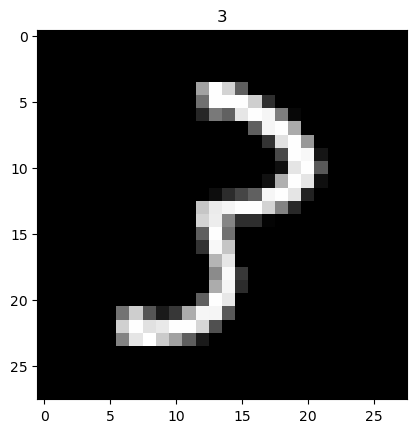

In [3]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
plt.imshow(img, cmap="gray")
plt.title(str(train_labels[0].numpy()))
plt.show()

In [4]:
print(len(train_dl), len(test_dl))

938 157


Training (with **Pytorch_Lightning**)

In [6]:
# !pip3 install pytorch_lightning
import pytorch_lightning as pl

In [7]:
# Cross-Entropy Custom
def my_cross_entropy(x, y):
    log_prob = -1.0 * F.log_softmax(x, 1)
    loss = log_prob.gather(1, y.unsqueeze(1))
    loss = loss.mean()
    return loss

class ResNetMNIST(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet50(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.loss = nn.CrossEntropyLoss()
#         self.loss = my_cross_entropy
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.005)

In [8]:
model = ResNetMNIST()
trainer = pl.Trainer(gpus=1, max_epochs=5, devices=1, accelerator="gpu")
trainer.fit(model, train_dl)

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 23.5 M
1 | loss  | CrossEntropyLoss | 0     
--

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [9]:
trainer.save_checkpoint("resnet18_mnist.pt")

In [10]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

inference_model = ResNetMNIST.load_from_checkpoint("resnet18_mnist.pt", map_location="cuda")

In [11]:
from tqdm.autonotebook import tqdm

true_y, pred_y = [], []
for batch in tqdm(iter(test_dl), total=len(test_dl)):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, inference_model)
    pred_y.extend(preds.cpu())

  0%|          | 0/157 [00:00<?, ?it/s]

In [12]:
from sklearn.metrics import classification_report
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.978     0.994     0.986       980
           1      0.985     0.996     0.991      1135
           2      0.994     0.990     0.992      1032
           3      0.995     0.985     0.990      1010
           4      0.976     0.994     0.985       982
           5      0.983     0.993     0.988       892
           6      0.995     0.965     0.979       958
           7      0.980     0.990     0.985      1028
           8      0.988     0.980     0.984       974
           9      0.992     0.975     0.984      1009

    accuracy                          0.987     10000
   macro avg      0.987     0.986     0.986     10000
weighted avg      0.987     0.987     0.986     10000

